## Импортирование необходимых библиотек и модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

## Чтение данных

In [2]:
data = pd.read_csv('/kaggle/input/sbermarket-internship-competition/train.csv')
sample_submission = pd.read_csv('/kaggle/input/sbermarket-internship-competition/sample_submission.csv')

## Просмотр и изучение данных (EDA)

In [3]:
data.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [5]:
sample_submission.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [7]:
# Переводим столбец order_completed_at в формат datetime
data['order_completed_at'] = pd.to_datetime(data['order_completed_at'])

In [8]:
# Создаем копию sample_submission, так как первоначальный формат пригодится для того, чтобы сделать сабмит
sample_copy = sample_submission.copy()

# Разделяем id на user_id и category_id
sample_copy[['user_id', 'cart']] = sample_copy['id'].str.split(';', expand=True)

# Преобразуем данные в числовой формат
sample_copy['user_id'] = sample_copy['user_id'].astype(int)
sample_copy['cart'] = sample_copy['cart'].astype(int)

# Выделаем нужные столбцы
sample_copy = sample_copy[['user_id','cart','target']]

# Проверка
sample_copy.head()

,user_id,cart,target
0,0,133,0
1,0,5,1
2,0,10,0
3,0,396,1
4,0,14,0


In [9]:
# Выводим данные о количестве пользователей и категорий в данных
print('Объем датасета:', data.shape[0])
print('Количество пользователей в train.csv:', data['user_id'].nunique())
print('Количество пользователей в sample_copy.csv:', sample_copy['user_id'].nunique())
print('Количество категорий в train.csv:', data['cart'].nunique())
print('Количество категорий в sample_copy.csv:', sample_copy['cart'].nunique())

Объем датасета: 3123064
Количество пользователей в train.csv: 20000
Количество пользователей в sample_copy.csv: 13036
Количество категорий в train.csv: 881
Количество категорий в sample_copy.csv: 858


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


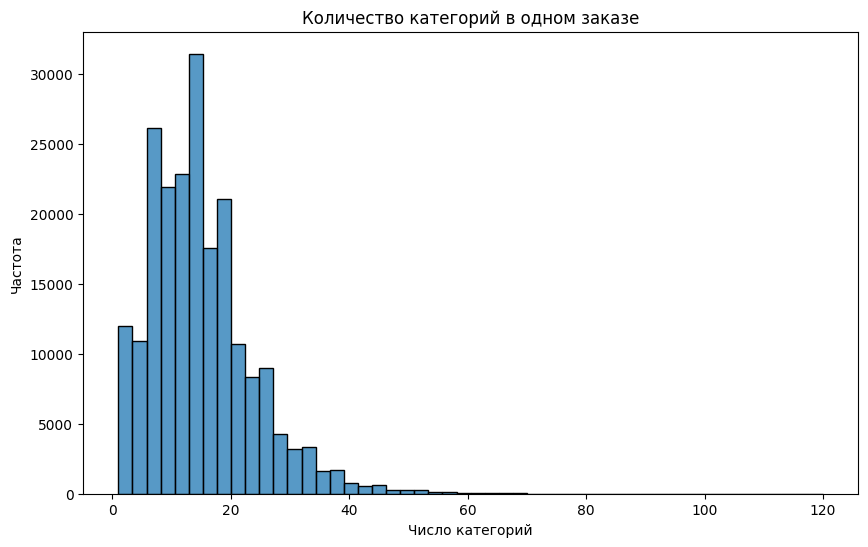

In [10]:
# Группируем данные, чтобы подсчитать количество категорий в одном заказе
order_category_counts = data.groupby(['user_id', 'order_completed_at'])['cart'].count()

# Построение гистограммы через seaborn
plt.figure(figsize=(10, 6))
sns.histplot(order_category_counts, bins=50, kde=False)

# Добавляем заголовок и метки осей
plt.title('Количество категорий в одном заказе')
plt.xlabel('Число категорий')
plt.ylabel('Частота')

# Отображение графика
plt.show()

In [11]:
# Выводим основные характеристики распределения количества категорий в заказах
order_category_counts

user_id  order_completed_at 
0        2020-07-19 09:59:17     8
         2020-08-24 08:55:32    25
         2020-09-02 07:38:25    11
1        2019-05-08 16:09:41     1
         2020-01-17 14:44:23     6
                                ..
19998    2020-09-01 08:12:32     7
         2020-09-02 15:03:23     4
19999    2020-08-31 18:54:24     1
         2020-08-31 19:32:08     1
         2020-08-31 20:08:24     1
Name: cart, Length: 209406, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


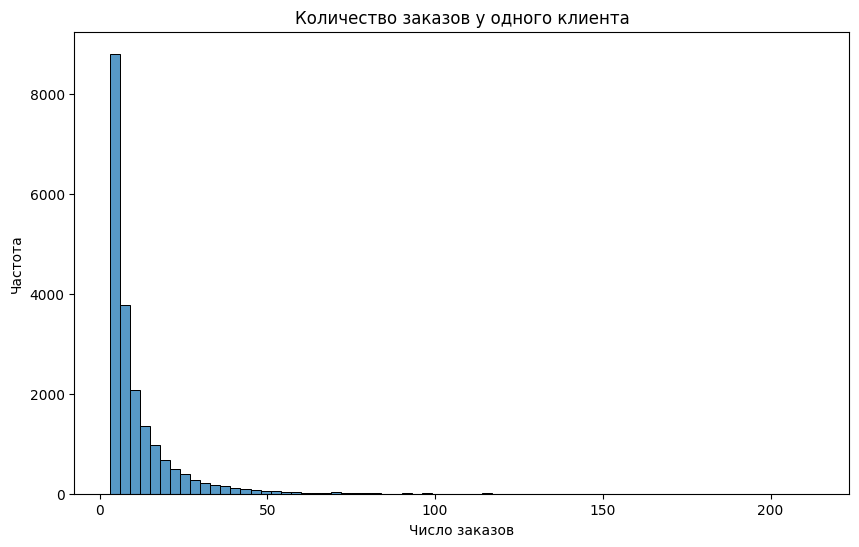

In [12]:
# Группируем данные по пользователям и считаем количество уникальных заказов
orders_per_user = data.groupby('user_id')['order_completed_at'].nunique()

# Построение гистограммы через seaborn
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user, bins=70, kde=False)

# Добавляем заголовок и метки осей
plt.title('Количество заказов у одного клиента')
plt.xlabel('Число заказов')
plt.ylabel('Частота')

# Отображение графика
plt.show()

In [13]:
# Выводим основные характеристики распределения количества уникальных заказов на одного пользователя
orders_per_user.describe()

count    20000.000000
mean        10.470300
std         11.905856
min          3.000000
25%          4.000000
50%          6.000000
75%         12.000000
max        213.000000
Name: order_completed_at, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


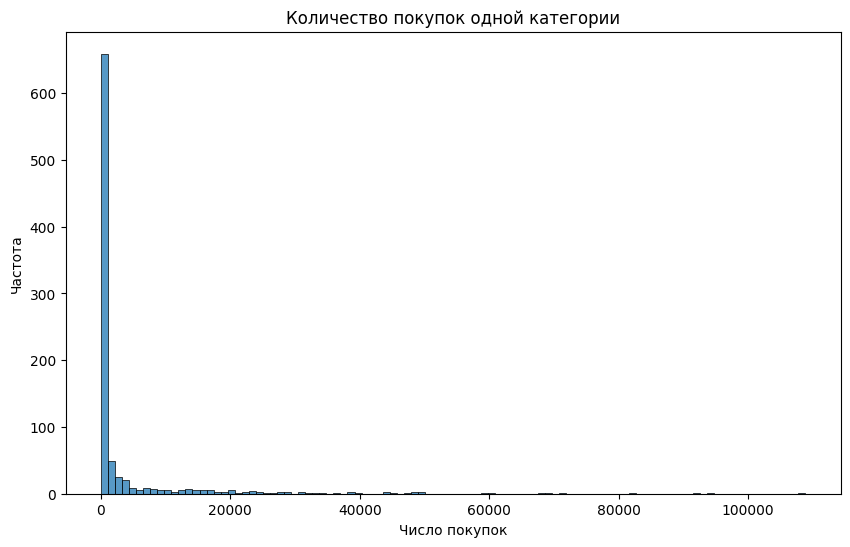

In [14]:
# Подсчет количества покупок для каждой категории
category_counts = data.groupby('cart').size()

# Построение гистограммы через seaborn
plt.figure(figsize=(10, 6))
sns.histplot(category_counts, bins=100, kde=False)

# Добавляем заголовок и метки осей
plt.title('Количество покупок одной категории')
plt.xlabel('Число покупок')
plt.ylabel('Частота')

# Отображение графика
plt.show()

In [15]:
category_counts.describe()

count       881.000000
mean       3544.908059
std       10686.317664
min           1.000000
25%           7.000000
50%          66.000000
75%        1101.000000
max      108877.000000
dtype: float64

## Создание обучающей выборки и датасета для предсказаний

In [16]:
# Создаем признак "номер заказа клиента"
data['order_number'] = data.groupby(['user_id'])['order_completed_at'].rank(method='dense').astype(int)

# Считаем общее количество заказов для каждого пользователя
count_orders = data.groupby('user_id')['order_number'].max().reset_index()
count_orders.rename(columns={'order_number': 'orders_count'}, inplace=True)

# Добавляем этот признак обратно в основной DataFrame
data = data.merge(count_orders, on='user_id', how='left')

# Определяем, является ли заказ последним
data['is_last_order'] = (data['order_number'] == data['orders_count']).astype(int)

In [17]:
data.head(5)

,user_id,order_completed_at,cart,order_number,orders_count,is_last_order
0,2,2015-03-22 09:25:46,399,1,15,0
1,2,2015-03-22 09:25:46,14,1,15,0
2,2,2015-03-22 09:25:46,198,1,15,0
3,2,2015-03-22 09:25:46,88,1,15,0
4,2,2015-03-22 09:25:46,157,1,15,0


In [18]:
# Разделяем данные на предыдущие и последние заказы
data_prev = data[data['is_last_order'] == 0].drop(columns=['order_completed_at', 'is_last_order'])
data_last = data[data['is_last_order'] == 1].drop(columns=['order_completed_at', 'order_number', 'orders_count'])

# Корректируем количество заказов в предыдущих данных
data_prev['orders_count'] -= 1

# Удаляем ненужные столбцы из основного DataFrame
data.drop(columns=['order_completed_at', 'is_last_order'], inplace=True)

In [19]:
# Проверяем результаты
print("Предыдущие заказы (data_prev):")
data_prev.head(5)

Предыдущие заказы (data_prev):


,user_id,cart,order_number,orders_count
0,2,399,1,14
1,2,14,1,14
2,2,198,1,14
3,2,88,1,14
4,2,157,1,14


In [20]:
print("Последние заказы (data_last):")
data_last.head(5)

Последние заказы (data_last):


,user_id,cart,is_last_order
1775824,12725,57,1
1775825,12725,99,1
1775826,12725,159,1
1775827,12725,420,1
1775828,12725,149,1


In [21]:
def create_data(X, data):
    # 1. mean_order_size
    order_size = (
        data.groupby(['user_id', 'order_number'])['cart']
        .count()
        .groupby(level=0)
        .mean()
        .reset_index(name='mean_order_size')
    )
    
    # 2. cart_count_all
    cart_count_all = (
        data.groupby('cart')['cart']
        .count()
        .reset_index(name='cart_count_all')
    )
    
    # 3. cart_count
    cart_count = (
        data.groupby(['user_id', 'cart'])['cart']
        .count()
        .reset_index(name='cart_count')
    )
    
    # 4. distance_to_last_order
    data['distance_to_last_order'] = data['orders_count'] - data['order_number']
    distances = (
        data.groupby(['user_id', 'cart'])['distance_to_last_order']
        .min()
        .reset_index()
    )
    
    # 5. last_order_with_cart
    last_order = (
        data.groupby(['user_id', 'cart'])['order_number']
        .max()
        .reset_index(name='last_order_with_cart')
    )
    
    # Массив слияний
    aggregated_features = [order_size, cart_count_all, cart_count, distances, last_order]
    for feature_df in aggregated_features:
        X = pd.merge(X, feature_df, on=list(feature_df.columns[:-1]), how='left')
    
    # Удаляем временные столбцы и заполняем NaN
    X.fillna(0, inplace=True)
    data.drop(columns='distance_to_last_order', inplace=True)

    return X

In [22]:
# Создаем копию sumple_submission, так как он пригодится нам потом для создания сабмита
X_train = sample_copy.copy()
X_test = sample_copy.copy()

In [23]:
X_train = create_data(X_train, data_prev)
X_test = create_data(X_test, data)

In [24]:
X_train.head(5)

,user_id,cart,target,mean_order_size,cart_count_all,cart_count,distance_to_last_order,last_order_with_cart
0,0,133,0,16.5,1328.0,1.0,0.0,2.0
1,0,5,1,16.5,27790.0,1.0,0.0,2.0
2,0,10,0,16.5,13307.0,1.0,0.0,2.0
3,0,396,1,16.5,24373.0,1.0,0.0,2.0
4,0,14,0,16.5,85164.0,2.0,0.0,2.0


In [25]:
# Убираем лишние колонки и удаляем дубликаты для предыдущих заказов
data_prev_orders_count = data_prev[['user_id', 'cart', 'orders_count']].drop_duplicates()

# Убираем лишние колонки и удаляем дубликаты для всех заказов
data_orders_count = data[['user_id', 'cart', 'orders_count']].drop_duplicates()

# Проверяем результы
data_orders_count.head(5)

,user_id,cart,orders_count
0,2,399,15
1,2,14,15
2,2,198,15
3,2,88,15
4,2,157,15


In [26]:
# Объединяем данные
X_train = pd.merge(X_train, data_prev_orders_count, on=['user_id', 'cart'], how='left')
X_test = pd.merge(X_test, data_orders_count, on=['user_id', 'cart'], how='left')

In [27]:
# Вычисляем частоту категории в заказах пользователя
X_train['cart_frequency'] = X_train['cart_count'] / X_train['orders_count']
X_test['cart_frequency'] = X_test['cart_count'] / X_test['orders_count']

In [28]:
# Если требуется подсчитать на основе уникальных пользователей и их orders_count
number_of_all_orders_prev = data_prev_orders_count.drop(columns='cart').drop_duplicates()['orders_count'].sum()
number_of_all_orders = data_orders_count.drop(columns='cart').drop_duplicates()['orders_count'].sum()

In [29]:
# Проверка значений
number_of_all_orders_prev, number_of_all_orders

(189406, 209406)

In [30]:
# Частота категории в заказах пользователя для тренировочных данных
X_train['cart_freq_all'] = X_train['cart_count_all'] / number_of_all_orders_prev
# Общая частота категории во всех заказах для тестовых данных
X_test['cart_freq_all'] = X_test['cart_count_all'] / number_of_all_orders

In [31]:
X_train.head()

,user_id,cart,target,mean_order_size,cart_count_all,cart_count,distance_to_last_order,last_order_with_cart,orders_count,cart_frequency,cart_freq_all
0,0,133,0,16.5,1328.0,1.0,0.0,2.0,2.0,0.5,0.007011
1,0,5,1,16.5,27790.0,1.0,0.0,2.0,2.0,0.5,0.146722
2,0,10,0,16.5,13307.0,1.0,0.0,2.0,2.0,0.5,0.070256
3,0,396,1,16.5,24373.0,1.0,0.0,2.0,2.0,0.5,0.128681
4,0,14,0,16.5,85164.0,2.0,0.0,2.0,2.0,1.0,0.449637


In [32]:
# Объединяем X_train с данными о последних заказах, создаем y_train и переводимм значения в int для обучения модели
y_train = X_train.merge(data_last[['user_id', 'cart', 'is_last_order']], 
                        on=['user_id', 'cart'], 
                        how='left')['is_last_order'].fillna(0).astype(np.int64)
y_train

0         0
1         0
2         0
3         0
4         0
         ..
790444    0
790445    0
790446    0
790447    1
790448    0
Name: is_last_order, Length: 790449, dtype: int64

## Обучение моделей

In [33]:
# Определяем гиперпараметры для перебора
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [8, 10],
    'learning_rate': [0.05, 0.1]
}

# Инициализируем модель XGBoost
base_model = XGBClassifier()

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model, 
    param_grid=param_grid, 
    scoring='f1',
    cv=5
)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Получаем лучшие параметры и результат
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучший F1-score:", best_score)

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
Лучший F1-score: 0.28968104024165875


In [34]:
# Cоздаем и обучаем модель
interval_model = grid_search.best_estimator_

In [35]:
# Создаем функцию для оптимизации порога
def optimal_threshold(start, end, delta, model, X, y):
    best_score = 0
    best_threshold = start
    # Предсказание вероятностей
    probs = model.predict_proba(X)
    
    while start <= end:
        # Генерация предсказаний по текущему порогу
        predictions = probs[:, 1] > start
        # Вычисление метрики
        score = f1_score(y, predictions)
        # Обновление лучшего порога, если метрика улучшилась
        if score > best_score:
            best_score = score
            best_threshold = start
        start += delta
    return best_score, best_threshold

In [36]:
# Сохраняем максимальный F1-score, достигнутый для оптимального порога и оптимальное значение порога вероятности, при котором достигнут максимальный F1-score
score, threshold = optimal_threshold(0.1, 0.8, 0.05, interval_model, X_train, y_train)

In [37]:
score, threshold

(0.6310885395899353, 0.3)

In [38]:
# Предсказания на тестовом наборе
probs = interval_model.predict_proba(X_test)

# Применяем оптимальный порог
target = probs[:, 1] > threshold

# Подготовка файла submission
sample_submission['target'] = target.astype(int)
sample_submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранен.")

Файл submission.csv сохранен.
